In [24]:
! wget https://worksheets.codalab.org/rest/bundles/0x550cd344825049bdbb865b887381823c/contents/blob/dataset_dog-fish_train-900_test-300.npz

--2023-12-15 05:23:59--  https://worksheets.codalab.org/rest/bundles/0x550cd344825049bdbb865b887381823c/contents/blob/dataset_dog-fish_train-900_test-300.npz
Resolving worksheets.codalab.org (worksheets.codalab.org)... 20.232.203.197
Connecting to worksheets.codalab.org (worksheets.codalab.org)|20.232.203.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/plain]
Saving to: ‘dataset_dog-fish_train-900_test-300.npz’

dataset_dog-fish_tr     [               <=>  ] 679.68M  12.8MB/s    in 56s     

2023-12-15 05:24:56 (12.2 MB/s) - ‘dataset_dog-fish_train-900_test-300.npz’ saved [712701930]



In [ ]:
! mv dataset_dog-fish_train-900_test-300.npz torch-influence/examples

In [ ]:
! cd torch-influence/ && python examples/analyze_dogfish.py

In [11]:
! wget https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz

--2023-12-15 05:18:24--  https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4832 (4.7K) [text/plain]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]   4.72K  --.-KB/s    in 0s      

2023-12-15 05:18:25 (39.7 MB/s) - ‘mnist.pkl.gz’ saved [4832/4832]



In [5]:
! pip install git+https://github.com/alstonlo/torch-influence.git

  Cloning https://github.com/alstonlo/torch-influence.git to /tmp/pip-req-build-1qtt8qrv
  Running command git clone --filter=blob:none --quiet https://github.com/alstonlo/torch-influence.git /tmp/pip-req-build-1qtt8qrv
  Resolved https://github.com/alstonlo/torch-influence.git to commit 8b4f0756acf642a38a8b24a517da89343a9de7d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-influence: filename=torch_influence-0.1.0-py3-none-any.whl size=14681 sha256=587398dde750fc3ef95aa795b0066541bfdb3fc3b1956b0884d186e935ecaf4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-16v__8jf/wheels/48/dc/b3/0fd624ebc8e58bdc1648b0538d4db2c0a2f81fc8ee71db04b0
Successfully built torch-influence
  Attempting uninstall: torch-influence
    Found existing installation: torch-influence 0.1.0
    Uninstalling torch-influence-0.1.0:
      Successfully uninstalled torch-influence-0.1.0


In [30]:
import pathlib

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from sklearn import linear_model
from torch import nn
from torch.utils import data
from tqdm import tqdm, trange

from torch_influence import BaseObjective, CGInfluenceModule


# Example-specific constants
BASE_DIR = '.'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DOGFISH_RAW_PATH = BASE_DIR + "/dataset_dog-fish_train-900_test-300.npz"
DOGFISH_EMB_PATH = BASE_DIR + "/dataset_dog-fish_embeds.npz"

DOGFISH_RAW_MMAP = np.load(str(DOGFISH_RAW_PATH), mmap_mode="r")

L2_WEIGHT = 1e-4


def load_dogfish_examples(split, idxs):
    image = DOGFISH_RAW_MMAP[f"X_{split}"][idxs]
    label = DOGFISH_RAW_MMAP[f"Y_{split}"][idxs]
    return image, label


def load_inception_embeds():
    if os.path.exists(DOGFISH_EMB_PATH):
        print(f"Using cached Inceptionv3 embeddings: {DOGFISH_EMB_PATH}")
        return np.load(str(DOGFISH_EMB_PATH))

    # load pretrained Inceptionv3
    model = torchvision.models.inception_v3(pretrained=True, transform_input=False)
    model.fc = nn.Identity()  # remove the last layer
    model.eval()
    model = model.to(DEVICE)

    embeds = {}

    for split in ("train", "test"):
        n = 2 * (900 if (split == "train") else 300)

        X, Y = [], []
        for idx in trange(0, n, 20, desc=f"Embedding Dogfish ({split})"):
            batch_idxs = [idx + offset for offset in range(20)]
            images, labels = load_dogfish_examples(split, batch_idxs)

            # getting Inceptionv3 embedding
            with torch.no_grad():
                images = torch.tensor(images, dtype=torch.float32, device=DEVICE)
                images = images.permute([0, 3, 1, 2])
                h = model(images).cpu().numpy()

            X.append(h)
            Y.append(labels)

        embeds[f"X_{split}"] = np.concatenate(X, axis=0).astype(np.float32)
        embeds[f"Y_{split}"] = np.concatenate(Y, axis=0).astype(np.float32)

    np.savez(str(DOGFISH_EMB_PATH), **embeds)
    return embeds


def fit_model(X, Y):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000)
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(2048, 1, bias=True)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Flatten(start_dim=-2),
        nn.Sigmoid()
    )

    pt_clf = pt_clf.to(device=DEVICE, dtype=torch.float32)
    return pt_clf


def captioned_image(model, embeds, split, idx, scores):
    x = embeds[f"X_{split}"][idx]
    y = embeds[f"Y_{split}"][idx].item()

    x = torch.tensor(x, device=DEVICE).unsqueeze(0)
    y_hat = model(x).round().item()

    # turn image into [0 .. 255] RGB image
    image, _ = load_dogfish_examples(split, idx)
    image = (image * 127.5) + 127.5
    image = image.clip(min=0.0, max=255.0)
    image = np.round(image).astype(np.uint8)

    # turn labels into human-readable strings
    class_names = ["dog", "fish"]
    label = class_names[int(y)]
    pred = class_names[int(y_hat)]

    if split == "test":
        score_caption = f"Test Loss: {scores[idx]:.5f}"
    else:
        score_caption = f"Influence: {scores[idx]:+.5f}"
    label_caption = f"Pred: {pred}, Label: {label}"
    return image, label_caption + "\n" + score_caption


print(f"Using {DEVICE}")

# ===========
# Load model and data
# ==========

embeds = load_inception_embeds()

X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])
train_set = data.TensorDataset(X_train, Y_train)

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])
test_set = data.TensorDataset(X_test, Y_test)

clf = fit_model(X_train, Y_train)

# ===========
# Get indices of top 5 test images with highest test loss
# ===========

test_losses = F.binary_cross_entropy(clf(X_test.to(DEVICE)), Y_test.to(DEVICE), reduction="none")
test_idxs = torch.argsort(test_losses, dim=0, descending=True)[:5]
test_idxs = test_idxs.tolist()

test_images = [captioned_image(clf, embeds, "test", idx, test_losses) for idx in test_idxs]

# ===========
# Initialize influence module using custom objective
# ===========

class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])

module = CGInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=1000,
)

# ===========
# For each test point:
#   1. Get the influence scores for all training points
#   2. Find the most helpful and harmful training points
# The most helpful point is that which, if removed, most increases the loss at the
# test point of interest (as predicted by the influence scores). Conversely, the most harmful
# test point is that which most decreases the test loss if removed.
# ===========

helpful_images = []
harmful_images = []

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    # In practice, this can be further optimized since we are recomputing the
    # loss gradients over the entire training dataset. With enough space, these
    # gradients can be cached instead.
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx])

    helpful = captioned_image(clf, embeds, "train", influences.argmax(), influences)
    harmful = captioned_image(clf, embeds, "train", influences.argmin(), influences)

    helpful_images.append(helpful)
    harmful_images.append(harmful)

image_grid = [test_images, helpful_images, harmful_images]

# ===========
# Plot image grid
# ==========

fig, axes = plt.subplots(nrows=3, ncols=len(image_grid[0]), sharex=True, sharey=True, figsize=(15, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.75)

# plot images
for row in zip(image_grid, axes):
    for ((image, caption), ax) in zip(*row):
        ax.set_title(caption, size="medium")
        ax.set(aspect="equal")
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

# draw separating lines
# Reference: https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots
def get_bbox(ax_):
    r = fig.canvas.get_renderer()
    return ax_.get_tightbbox(r).transformed(fig.transFigure.inverted())

bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)
xmax = np.array(list(map(lambda b: b.x1, bboxes.flat))).reshape(axes.shape).max(axis=0)
xmin = np.array(list(map(lambda b: b.x0, bboxes.flat))).reshape(axes.shape).min(axis=0)
xs = np.c_[xmax[1:], xmin[:-1]].mean(axis=1)

for x in xs:
    line = plt.Line2D([x, x], [0.03, 0.97], transform=fig.transFigure, color="black", linewidth=1.2)
    fig.add_artist(line)

# write row labels
row_labels = ["Test Image", "Most Helpful", "Most Harmful"]
for ax, label in zip(axes[:, 0], row_labels):
    ax.set_ylabel(label, rotation=90, size="x-large", fontweight="bold")

fig.savefig("dogfish_influences.png", dpi=300)

Using cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:05<00:00, 20.8MB/s]
Embedding Dogfish (test): 100%|██████████| 30/30 [02:07<00:00,  4.23s/it]


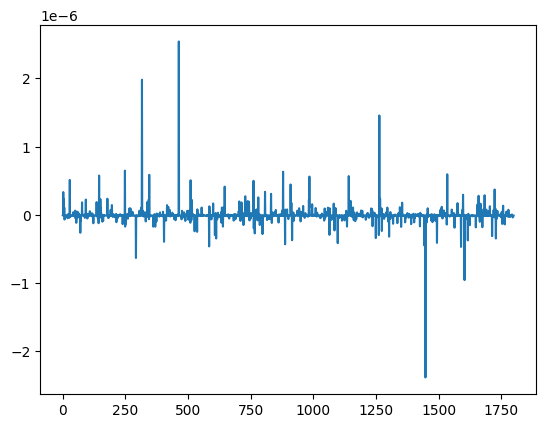

In [36]:
influences = module.influences(train_idxs=all_train_idxs, test_idxs=[0])
plt.plot(influences.numpy())

(array([1.639e+03, 8.100e+01, 3.300e+01, 1.600e+01, 1.000e+01, 7.000e+00,
        5.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([6.54255122e-12, 8.46391330e-08, 1.69271729e-07, 2.53904318e-07,
        3.38536921e-07, 4.23169496e-07, 5.07802099e-07, 5.92434674e-07,
        6.77067248e-07, 7.61699880e-07, 8.46332455e-07, 9.30965030e-07,
        1.01559760e-06, 1.10023018e-06, 1.18486287e-06, 1.26949544e-06,
        1.35412802e-06, 1.43876059e-06, 1.52339317e-06, 1.60802574e-06,
        1.69265843e-06, 1.77729100e-06, 1.86192358e-06, 1.94655604e-06,
        2.03118884e-06, 2.11582142e-06, 2.20045399e-06, 2.28508657e-06,
        2.36971914e-06, 2.45435172e-06, 2.53898429e-06]),
 <BarContainer object of 30 artists>)

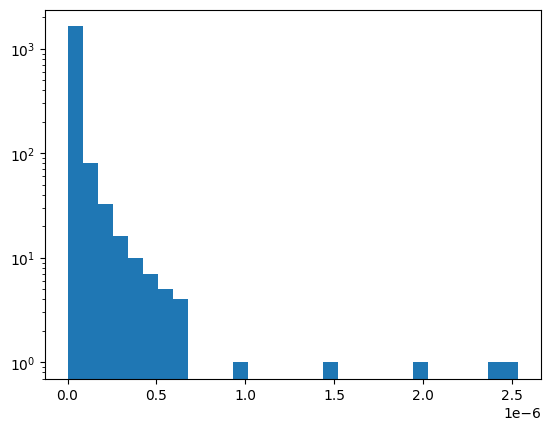

In [51]:
plt.hist(np.absolute(influences), log=True, bins=30)